In [28]:
##### Imports #####
import os
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.scale as scl


In [29]:
##### Config #####
# paths
path_to_sample = "./outputs/salad-irg-pacbio-hifi"
assemblers=["metaMDBG", "hifiasm-meta", "metaflye"]

#bin quality
criteria = ["Completeness","Contamination","Strain hetero","Contigs","Size","N50","N50/Size"]
x_criteria = 0
y_criteria = 1


In [30]:
##### Create bin mag_table #####

# Create mag_table
mag_table = pd.DataFrame({
    "Bin name" : pd.Series(dtype='str'),
    "Assembler" : pd.Series(dtype='str') })
for c in criteria : 
    mag_table[c] = pd.Series(dtype='float')

# Fill mag_table
for a in assemblers :
    with open(path_to_sample + "/" + a + "/bin_quality_based_report.txt", "r") as report_file :
        lines = report_file.readlines()

    criteria_values = {}
    for l in lines[6:] :
        l = l.strip().split()
        table_line = [l[1], a]
        for c in range(len(criteria)) : 
            table_line.append(float(l[13 + c]))
        mag_table.loc[len(mag_table)] = table_line

# Sort mag_table
mag_table.sort_values([criteria[x_criteria], criteria[y_criteria]], inplace = True)

# Define quality
def GSCS_quality(contamination, completeness, contigs, size) : 
    if ((contamination <=1) and (completeness >=99) and (contigs <=1)) : 
        return "near complete"   
    if ((contamination <=5) and (completeness >=90)) :
        return "high quality"     
    if ((contamination <=10) and (completeness >=50)) :
        return "medium quality"   
    return "low quality"

def metamdbg_quality(contamination, completeness, contigs, size) : 
    if ((contamination <=5) and (completeness >=90)) : 
        return "near complete"   
    if ((contamination <=10) and (completeness >=70)) :
        return "high quality"     
    if ((contamination <=10) and (completeness >=50)) :
        return "medium quality"   
    return "low quality"

mag_table["Quality"] = mag_table.apply(lambda x: GSCS_quality(x['Contamination'], x['Completeness'], x['Contigs'], x['Size']), axis=1)

mag_table


,Bin name,Assembler,Completeness,Contamination,Strain hetero,Contigs,Size,N50,N50/Size,Quality
9,bin.107,metaMDBG,0.0,0.00,0.00,21.0,262675.0,13429.0,0.051124,low quality
12,bin.11,metaMDBG,0.0,0.00,0.00,65.0,457538.0,7538.0,0.016475,low quality
15,bin.112,metaMDBG,0.0,0.00,0.00,57.0,513262.0,10031.0,0.019544,low quality
17,bin.114,metaMDBG,0.0,0.00,0.00,34.0,292180.0,8516.0,0.029146,low quality
19,bin.116,metaMDBG,0.0,0.00,0.00,33.0,346077.0,11346.0,0.032785,low quality
...,...,...,...,...,...,...,...,...,...,...
371,bin.73,metaMDBG,100.0,1637.13,2.37,22928.0,123643384.0,5808.0,0.000047,low quality
216,bin.294,metaMDBG,100.0,1673.87,10.12,20115.0,111401792.0,5940.0,0.000053,low quality
966,bin.609,hifiasm-meta,100.0,1918.55,23.15,19.0,534326.0,30304.0,0.056714,low quality
247,bin.321,metaMDBG,100.0,2364.90,8.43,22087.0,146720791.0,7310.0,0.000050,low quality


/home/nimauric/.conda/envs/datavis/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nimauric/.conda/envs/datavis/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nimauric/.conda/envs/datavis/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nimauric/.conda/envs/datavis/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future v

[Text(0, 0.5, 'number of bins')]

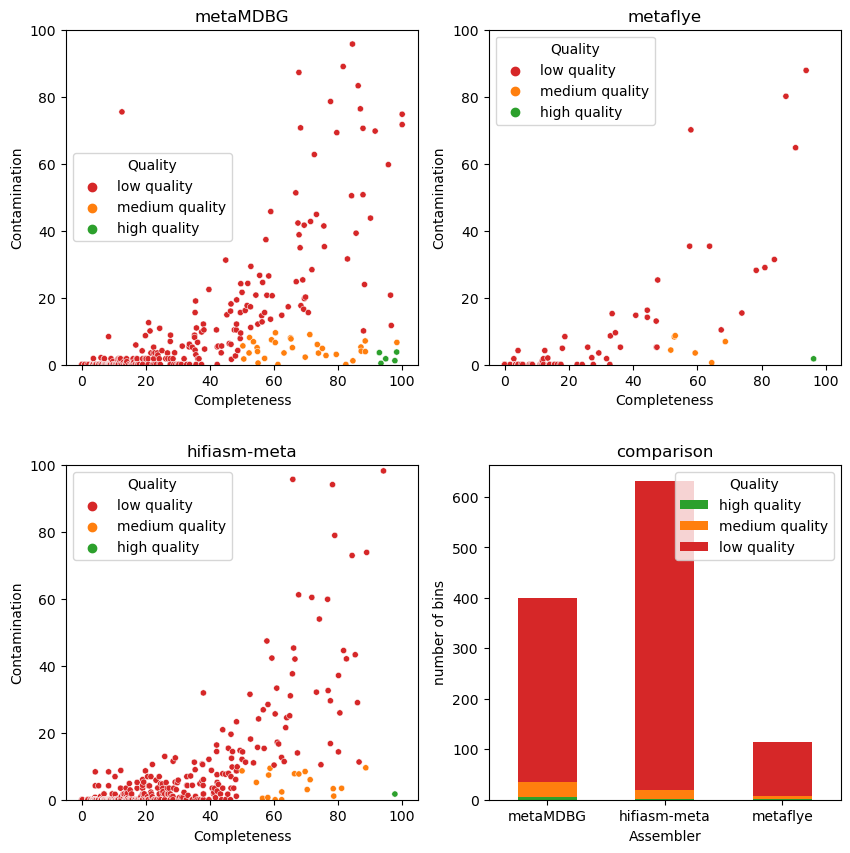

In [71]:
##### Plotting by MAG quality #####

custom_palette = {
    'near complete': '#1f77b4',
    'high quality': '#2ca02c',
    'medium quality': '#ff7f0e',
    'low quality': '#d62728'
}

def scatter_plotter(assembler, ax) : 
    plot = sns.scatterplot(data=mag_table[mag_table["Assembler"] == assembler], 
        x=criteria[x_criteria], y=criteria[y_criteria], hue='Quality', 
        palette=custom_palette, s=20, alpha=1, ax=axes.flatten()[ax])
    plot.set_ylim(0,100)
    plot.set(title=assembler)



fig, axes = plt.subplots(2, 2, figsize=(10, 10))
plt.subplots_adjust(hspace=0.3, wspace = 0.2)
scatter_plotter("metaMDBG", 0)
scatter_plotter("metaflye", 1)
scatter_plotter("hifiasm-meta", 2)

pivot_table = mag_table.pivot_table(index='Assembler', columns='Quality', aggfunc='size', fill_value=0)
pivot_table = pivot_table.reset_index()
pivot_table = pivot_table.reindex(columns=["Assembler", "near complete", "high quality", "medium quality", "low quality"], fill_value=0)
pivot_table = pivot_table.loc[:, (pivot_table != 0).any(axis=0)]
tmp = pivot_table.iloc[1]
pivot_table.iloc[1] = pivot_table.iloc[0]
pivot_table.iloc[0] = tmp

plot = pivot_table.plot(kind = "bar", stacked = True, color=custom_palette,
        x="Assembler",ax=axes.flatten()[3])
plot.set(title="comparison")
plot.set_xticklabels(labels = plot.get_xticklabels(),rotation = 0)
axes.flatten()[3].set(ylabel= "number of bins")



In [69]:


pivot_table

Quality,Assembler,high quality,medium quality,low quality
0,metaMDBG,5,31,364
1,hifiasm-meta,1,18,613
2,metaflye,1,6,108


/home/nimauric/.conda/envs/datavis/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nimauric/.conda/envs/datavis/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nimauric/.conda/envs/datavis/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nimauric/.conda/envs/datavis/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future v

'\nfig, axes = plt.subplots(2, 2, figsize=(10, 10))\nplt.subplots_adjust(hspace=0.3, wspace = 0.2)\nbarplot_plotter("Aligned Illumina reads count", 0)\nbarplot_plotter("Aligned Illumina reads length", 1)\nbarplot_plotter("Aligned Illumina reads count", 2, ratio=True)\nbarplot_plotter("Aligned Illumina reads length", 3, ratio=True)\n'

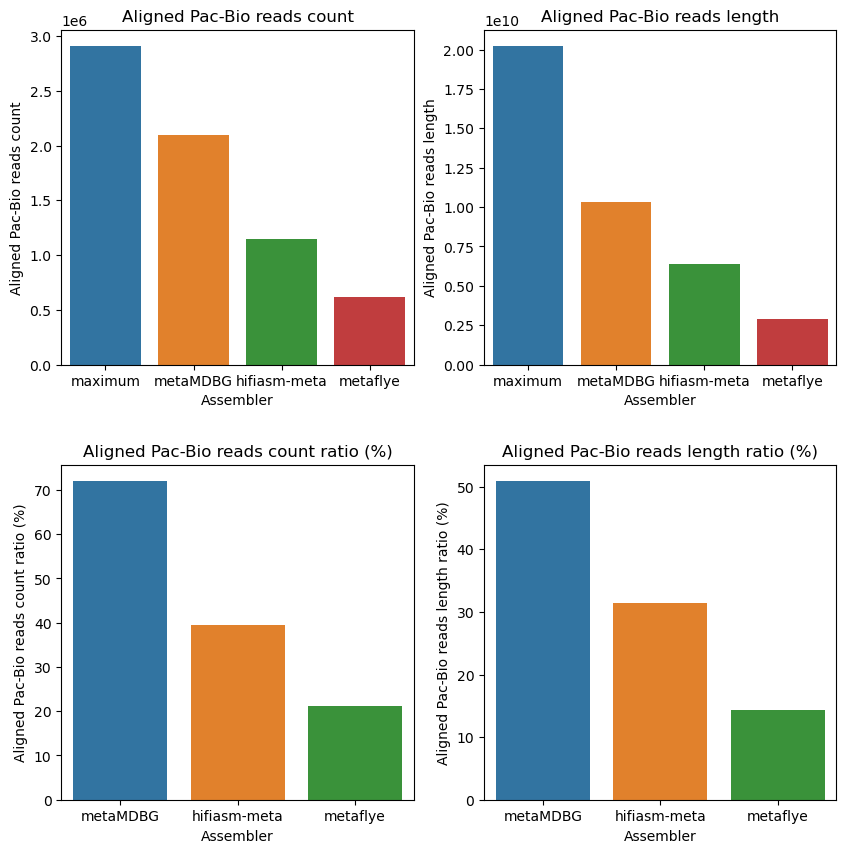

In [38]:
##### Create align_table #####

# Create align_table
align_table = pd.DataFrame({
    "Assembler" : pd.Series(dtype='str'),
    "Aligned Pac-Bio reads count" : pd.Series(dtype='int'),
    "Aligned Pac-Bio reads length" : pd.Series(dtype='int'),
    "Aligned Illumina reads count" : pd.Series(dtype='int'),
    "Aligned Illumina reads length" : pd.Series(dtype='int'),
     })


# Fill align_table
for a in assemblers :
    with open(path_to_sample + "/" + a + "/reference_free_report.txt", "r") as report_file :
        lines = report_file.readlines()
    
    #with open(path_to_sample + "/" + a + "/reference_free_sample_comparison_report.txt", "r") as report_file :
    #    lines_sample_comparison = report_file.readlines()

    if(len(align_table) == 0) : 
        #align_table.loc[0] = ["maximum", int(lines[1][24:-1]), int(lines[5][21:-1]), int(lines_sample_comparison[1][24:-1]), int(lines_sample_comparison[5][21:-1])]
        align_table.loc[0] = ["maximum", int(lines[1][24:-1]), int(lines[5][21:-1]), 0,0]

    #align_table.loc[len(align_table)] = [a, int(lines[0][25:-1]), int(lines[4][26:-1]), int(lines_sample_comparison[0][25:-1]), int(lines_sample_comparison[4][26:-1])] # To get ratio instead of number / length
    align_table.loc[len(align_table)] = [a, int(lines[0][25:-1]), int(lines[4][26:-1]), 0,0] # To get ratio instead of number / length


# plot 
def barplot_plotter(metric, ax, ratio=False) : 
    title = metric
    data = align_table.copy()
    if ratio :
        data["Aligned Pac-Bio reads count"] /= data.loc[0, "Aligned Pac-Bio reads count"]/100
        data["Aligned Pac-Bio reads length"] /= data.loc[0,  "Aligned Pac-Bio reads length"]/100
        data["Aligned Illumina reads count"] /= data.loc[0, "Aligned Illumina reads count"]/100
        data["Aligned Illumina reads length"] /= data.loc[0,  "Aligned Illumina reads length"]/100
        data = data.drop(index=0)
        title = metric + " ratio (%)"

    plot = sns.barplot(data=data, 
        x="Assembler",
        y=metric, 
        ax=axes.flatten()[ax])
    if(ratio) : 
        axes.flatten()[ax].set(ylabel= metric + " ratio (%)")

    plot.set(title=title)
    plot.set_xticklabels(labels = plot.get_xticklabels(),rotation = 0)


fig, axes = plt.subplots(2, 2, figsize=(10, 10))
plt.subplots_adjust(hspace=0.3, wspace = 0.2)
barplot_plotter("Aligned Pac-Bio reads count", 0)
barplot_plotter("Aligned Pac-Bio reads length", 1)
barplot_plotter("Aligned Pac-Bio reads count", 2, ratio=True)
barplot_plotter("Aligned Pac-Bio reads length", 3, ratio=True)
"""
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
plt.subplots_adjust(hspace=0.3, wspace = 0.2)
barplot_plotter("Aligned Illumina reads count", 0)
barplot_plotter("Aligned Illumina reads length", 1)
barplot_plotter("Aligned Illumina reads count", 2, ratio=True)
barplot_plotter("Aligned Illumina reads length", 3, ratio=True)
"""


In [ ]:


bin_aware_align_table = mag_table[["Bin name", "Assembler", "Quality"]]

per_bin_alignement = None
for a in assemblers :
    #print(path_to_sample + "/" + a +"/reference_free/per_bin_mapping.csv")
    tmp = pd.read_csv(path_to_sample + "/" + a +"/reference_free/per_bin_mapping.csv") 
    tmp["Assembler"] = a
    if per_bin_alignement is None : 
        per_bin_alignement = tmp 
    else : 
        per_bin_alignement = pd.concat ([per_bin_alignement, tmp])
    
per_bin_alignement.rename(columns={"bin": "Bin name", "aligned_read_number" : "Aligned Pac-Bio reads count", "aligned_read_bases" : "Aligned Pac-Bio reads length"}, inplace=True)
bin_aware_align_table = pd.merge(bin_aware_align_table, per_bin_alignement, how="outer", on=["Bin name", "Assembler"])
bin_aware_align_table = bin_aware_align_table.groupby(["Assembler","Quality"]).sum().reset_index()


bin_aware_align_table = bin_aware_align_table.pivot_table(index='Assembler', columns='Quality', aggfunc='sum', fill_value=0).reset_index()
bin_aware_align_table = bin_aware_align_table.reindex([
    ("Assembler", ''),
    ('Aligned Pac-Bio reads count', 'near complete'), 
    ('Aligned Pac-Bio reads count', 'high quality'), 
    ('Aligned Pac-Bio reads count','medium quality'),
    ('Aligned Pac-Bio reads count','low quality'),
    ('Aligned Pac-Bio reads length', 'near complete'), 
    ('Aligned Pac-Bio reads length', 'high quality'), 
    ('Aligned Pac-Bio reads length','medium quality'),
    ('Aligned Pac-Bio reads length','low quality'),
    ], fill_value=0, axis=1)

bin_aware_align_table

Assembler Aligned Pac-Bio reads count                              \
Quality                             near complete high quality medium quality   
0        hifiasm-meta                           0          597          18991   
1            metaMDBG                           0        43136         125572   
2            metaflye                           0         5064          35061   

                    Aligned Pac-Bio reads length                              \
Quality low quality                near complete high quality medium quality   
0           1118201                            0      2980395       79713432   
1           1794725                            0    274799811      687834878   
2            569340                            0     30341022      141140588   

                     
Quality low quality  
0        5418619347  
1        3370875506  
2        2084742755

2913016
20251105762


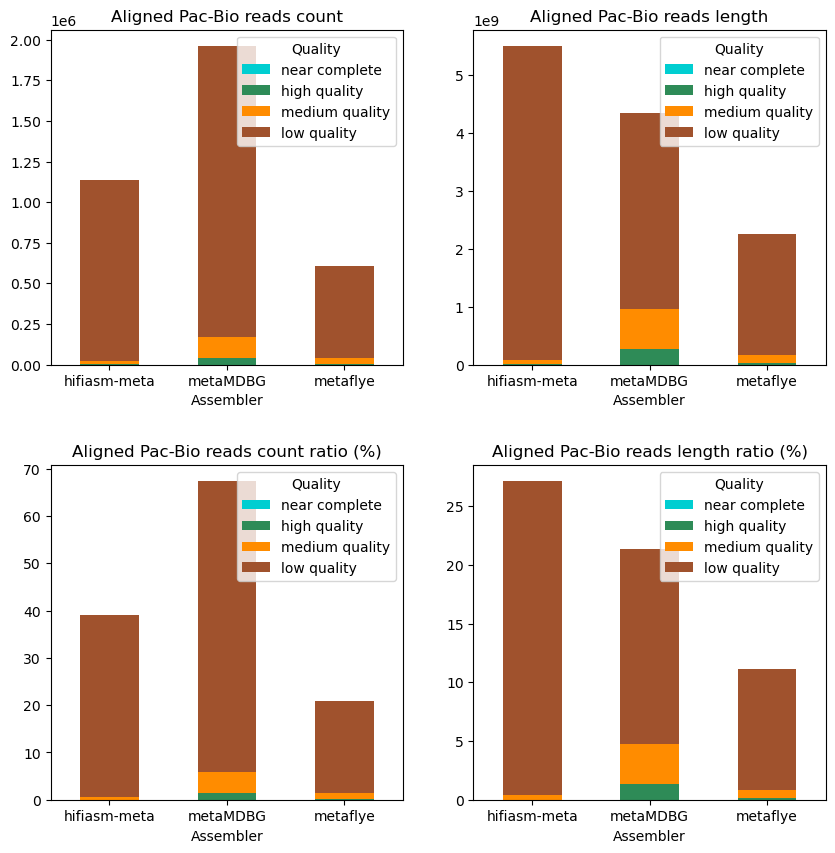

In [ ]:
# plot 


def barplot_plotter(metric, ax, ratio=False) : 
    title = metric
    data = bin_aware_align_table[["Assembler", metric]].copy()
    if ratio :
        print(align_table.loc[0, metric])
        data[(metric, 'near complete')] /= align_table.loc[0, metric]/100
        data[(metric, 'high quality')] /= align_table.loc[0, metric]/100
        data[(metric, 'medium quality')] /= align_table.loc[0, metric]/100
        data[(metric, 'low quality')] /= align_table.loc[0, metric]/100
    
        title = metric + " ratio (%)"
        
    plot = data.plot(kind = "bar", stacked = True, x="Assembler",y = metric,ax=axes.flatten()[ax], color=custom_palette)
    plot.set(title=title)
    plot.set_xticklabels(labels = plot.get_xticklabels(),rotation = 0)

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
plt.subplots_adjust(hspace=0.3, wspace = 0.2)
barplot_plotter("Aligned Pac-Bio reads count", 0)
barplot_plotter("Aligned Pac-Bio reads length", 1)
barplot_plotter("Aligned Pac-Bio reads count", 2, ratio=True)
barplot_plotter("Aligned Pac-Bio reads length", 3, ratio=True)



In [ ]:
bin_aware_align_table

Assembler Aligned Pac-Bio reads count                              \
Quality                             near complete high quality medium quality   
0        hifiasm-meta                           0          597          18991   
1            metaMDBG                           0        43136         125572   
2            metaflye                           0         5064          35061   

                    Aligned Pac-Bio reads length                              \
Quality low quality                near complete high quality medium quality   
0           1118201                            0      2980395       79713432   
1           1794725                            0    274799811      687834878   
2            569340                            0     30341022      141140588   

                     
Quality low quality  
0        5418619347  
1        3370875506  
2        2084742755

In [ ]:
print(5064 + 35061 + 569340)

align_table

609465


,Assembler,Aligned Pac-Bio reads count,Aligned Pac-Bio reads length,Aligned Illumina reads count,Aligned Illumina reads length
0,maximum,2913016,20251105762,0,0
1,metaflye,615536,2905382547,0,0
2,hifiasm-meta,1148735,6352534206,0,0
